# Weather Dataset Preprocessing

A dataset that has a collection of weather observations from the city of Aarhus, spanning from Feb through Sept in 2014 excluding July. 

In [3]:
import tarfile
import pandas as pd
import os
import json
from pathlib import Path
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# get weather data files (zip and tar.gz)
file_list = []
for root, dirs, files in os.walk('../data'):
    files.sort()
    for file in files:
        if 'weather' in file.lower():  # Search for the string 'weather' (case insensitive)
            file_list.append(os.path.join(root, file))

print(file_list)

['../data/raw_weather_data_aarhus.tar.gz', '../data/raw_weather_data_aug_sep_2014.zip']


In [5]:
weather_data1 = []
if file_list[0].endswith('.tar.gz'):
    with tarfile.open(file_list[0], 'r:gz') as tar:
        variables = tar.getnames() # saves the names of the files within the tar.gz

        all_data = []

        for variable in variables:
            extracted_file = tar.extractfile(variable)
            file_content = extracted_file.read().decode('utf-8')

            # Split content into multiple JSON objects (each file line is a json object)
            json_objects = file_content.strip().split('\n')

            variable_name = Path(variable).stem
            variable_data = []

            for obj in json_objects:
                # Parse each JSON object and convert it to a dataframe
                data_dict = json.loads(obj)
                df = pd.DataFrame(list(data_dict.items()), columns=['Datetime', variable_name])
                
                # Convert the Datetime column to a pandas datetime format and use it as the index
                df['Datetime'] = pd.to_datetime(df['Datetime'])
                df.set_index('Datetime', inplace=True)
                
                # Append each line to the variable dataframe
                variable_data.append(df)
            variable_final = pd.concat(variable_data)
            all_data.append(variable_final)
        
        # did outer joint to keep all indicies and fill NaN values for missing data
        weather_data1 = pd.concat(all_data, axis=1, join='outer')
        
print(weather_data1)

                    dewptm pressurem wdird tempm  vism wspdm hum
Datetime                                                        
2014-02-13 06:20:00    2.0       989   170   3.0  10.0  16.7  93
2014-02-13 13:50:00    1.0       989   200   7.0  10.0  14.8  66
2014-02-13 06:00:00      1       990   170     2    11  13.0  91
2014-02-13 03:00:00      1       992   150     3     8  20.4  84
2014-02-13 13:00:00      1       990   190     6    24  20.4  62
...                    ...       ...   ...   ...   ...   ...  ..
2014-06-08 18:00:00     13      1020   170    20    35   7.4  54
2014-06-08 09:00:00     11      1020   170    18    45  11.1  52
2014-06-08 09:20:00   11.0      1019   160  18.0  10.0   9.3  64
2014-06-08 09:50:00   12.0      1019   120  19.0  10.0   7.4  64
2014-06-08 05:20:00    9.0      1018   180  12.0  10.0   3.7  82

[8222 rows x 7 columns]


In [6]:
weather_data2 = []
# Check if the file is a zip file
if file_list[1].endswith('.zip'):
    with zipfile.ZipFile(file_list[1], 'r') as zip_ref:
        # Get the list of files in the zip archive
        variables = [file for file in zip_ref.namelist() if file.endswith('.txt') and not file.startswith('__MACOSX')]
        print(zip_ref.namelist())
        all_data = []

        for variable in variables:
            # Extract the file content from the zip file
            with zip_ref.open(variable) as extracted_file:
                file_content = extracted_file.read().decode('utf-8')

                # Split content into multiple JSON objects (each line is a JSON object)
                json_objects = file_content.strip().split('\n')

                # Use the file name (without extension) as the variable name
                variable_name = Path(variable).stem
                variable_data = []

                for obj in json_objects:
                    # Parse each JSON object and convert it into a DataFrame
                    data_dict = json.loads(obj)
                    df = pd.DataFrame(list(data_dict.items()), columns=['Datetime', variable_name])
                    
                    # Convert the 'Datetime' column to pandas datetime format and set it as the index
                    df['Datetime'] = pd.to_datetime(df['Datetime'])
                    df.set_index('Datetime', inplace=True)
                    
                    # Append each DataFrame to the list of variable data
                    variable_data.append(df)
                
                # Concatenate the DataFrames for this variable
                variable_final = pd.concat(variable_data)
                all_data.append(variable_final)

        # Concatenate all DataFrames with an outer join to match indices (Datetime)
        weather_data2 = pd.concat(all_data, axis=1, join='outer')
        
weather_data2 = pd.DataFrame(weather_data2)  # Convert to DataF
# Print the final combined DataFrame
print(weather_data2)

['dewptm.txt', '__MACOSX/', '__MACOSX/._dewptm.txt', 'hum.txt', '__MACOSX/._hum.txt', 'pressurem.txt', '__MACOSX/._pressurem.txt', 'tempm.txt', '__MACOSX/._tempm.txt', 'wdird.txt', '__MACOSX/._wdird.txt', 'wspdm.txt', '__MACOSX/._wspdm.txt']
                    dewptm hum pressurem tempm wdird wspdm
Datetime                                                  
2014-08-01 01:00:00     13  64      1012    18   210   7.4
2014-08-01 13:00:00     15  53      1013    22   180  11.1
2014-08-01 01:20:00   13.0  73      1012  18.0   210   7.4
2014-08-01 13:20:00   13.0  57      1013  22.0   180  14.8
2014-08-01 13:50:00   12.0  47      1013  24.0   170  14.8
...                    ...  ..       ...   ...   ...   ...
2014-09-30 18:00:00      9  63      1025    14   100   9.3
2014-09-30 04:00:00     11  84      1024    13   100   5.6
2014-09-30 03:20:00   12.0  88      1023  14.0   100   3.7
2014-09-30 04:20:00   12.0  88      1023  14.0    80   7.4
2014-09-30 18:20:00    9.0  72      1025  14.0   1

In [7]:
weather_data = pd.concat([weather_data1, weather_data2], axis=0)
weather_data

,dewptm,pressurem,wdird,tempm,vism,wspdm,hum
Datetime,,,,,,,
2014-02-13 06:20:00,2.0,989,170,3.0,10.0,16.7,93
2014-02-13 13:50:00,1.0,989,200,7.0,10.0,14.8,66
2014-02-13 06:00:00,1,990,170,2,11,13.0,91
2014-02-13 03:00:00,1,992,150,3,8,20.4,84
2014-02-13 13:00:00,1,990,190,6,24,20.4,62
...,...,...,...,...,...,...,...
2014-09-30 18:00:00,9,1025,100,14,NaN,9.3,63
2014-09-30 04:00:00,11,1024,100,13,NaN,5.6,84
2014-09-30 03:20:00,12.0,1023,100,14.0,NaN,3.7,88


In [18]:
weather_data = weather_data.apply(pd.to_numeric, errors='coerce')
weather_data.info()
weather_data = weather_data.reset_index()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12579 entries, 2014-02-13 06:20:00 to 2014-09-30 18:20:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   dewptm     12563 non-null  float64
 1   pressurem  12558 non-null  float64
 2   wdird      12463 non-null  float64
 3   tempm      12563 non-null  float64
 4   vism       7876 non-null   float64
 5   wspdm      12509 non-null  float64
 6   hum        12563 non-null  float64
dtypes: float64(7)
memory usage: 786.2 KB


In [19]:
weather_data.describe()

,Datetime,dewptm,pressurem,wdird,tempm,vism,wspdm,hum
count,12579,12563.000000,12558.000000,12463.000000,12563.000000,7876.000000,12509.000000,12563.000000
mean,2014-05-31 02:29:11.953255424,6.353260,1013.707836,183.417315,11.325082,13.046350,13.028883,70.785083
min,2014-02-13 00:00:00,-9.000000,986.000000,0.000000,-3.000000,0.000000,0.000000,12.000000
25%,2014-03-29 12:55:00,3.000000,1008.000000,110.000000,7.000000,9.000000,7.400000,61.000000
50%,2014-05-12 20:20:00,7.000000,1014.000000,190.000000,11.000000,10.000000,11.100000,74.000000
75%,2014-08-18 00:10:00,10.000000,1020.000000,260.000000,15.000000,10.000000,16.700000,82.000000
max,2014-09-30 23:50:00,19.000000,1038.000000,360.000000,27.000000,50.000000,64.800000,100.000000
std,NaN,4.648668,8.981195,88.411577,5.420558,10.548018,8.059656,15.669026


<Axes: >

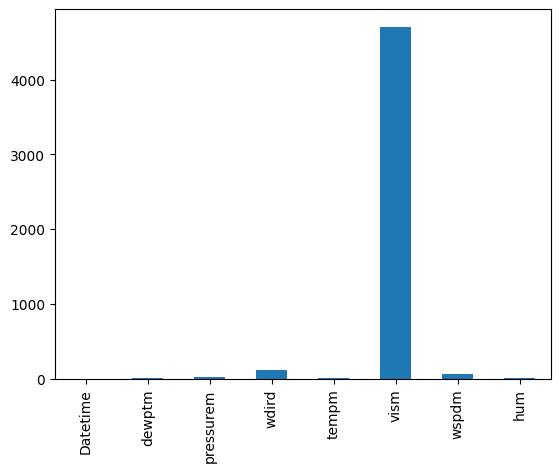

In [20]:
weather_data.replace(-9999.0, np.nan, inplace=True)
weather_data.isna().sum().plot.bar()

array([<Axes: xlabel='Datetime'>, <Axes: xlabel='Datetime'>,
       <Axes: xlabel='Datetime'>, <Axes: xlabel='Datetime'>,
       <Axes: xlabel='Datetime'>], dtype=object)

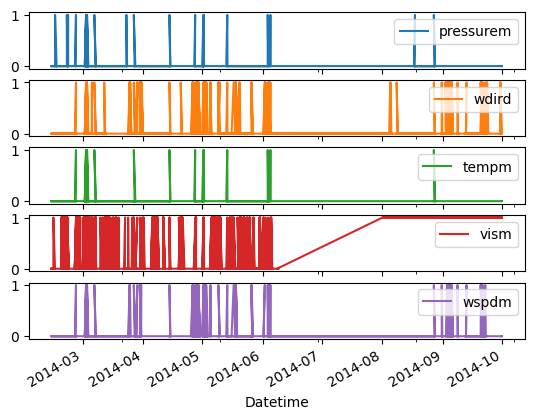

In [24]:
weather_na = weather_data.drop('Datetime', axis = 1).isna().groupby(weather_data.Datetime, sort = False).sum().reset_index()
weather_na.plot(x='Datetime', y=weather_na.columns[2:-1], subplots=True)

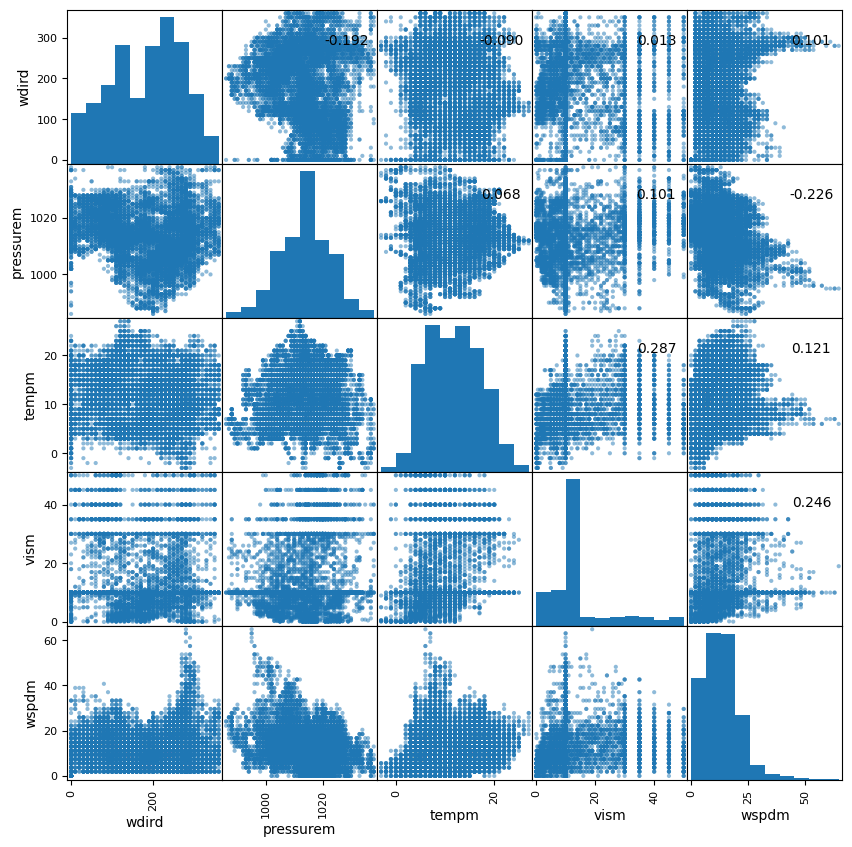

In [25]:
axes = pd.plotting.scatter_matrix(weather_data[['wdird', 'pressurem', 'tempm', 'vism', 'wspdm']], alpha=0.5,figsize = [10,10])
corr = weather_data[['wdird', 'pressurem', 'tempm', 'vism', 'wspdm']].corr(method = 'spearman').to_numpy() #nonlinear
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()